
## Inference and Validation
- Remove overfitting
- To test for overfitting while training, we measure the performance on data not in the training set called the validation set.
- Do **regularization** such as dropout


In [1]:
#Getting Data
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data , make train = False
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [2]:
#Define Model 
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x


## ACCURACY
### Methos
- Precision and recall 
- top-5 error rate
- Accuracy

- **ps.topk** method - This returns the $k$ highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we'll get back 4 as the index.

In [3]:
# Method To Calculate Accuracy (Model has not been train it is random accuracy)
# Performing a single forward pass

model = Classifier()
images , labels = next(iter(trainloader))

# Getting class probabilities for only first 64 images batch
ps = torch.exp(model(images))

#Making sure the shape of output is appropriate , we get 10 classes
print(ps.shape)



torch.Size([64, 10])


In [4]:
# Comparing ps , get which class has maximum probabilities
# tensor.topk returns two tensors - one having maximum probabilities , other having clases with those peobabilities
# tensor.topk( number of top elements , comparing between row or column - dim)
top_p , top_class = ps.topk(1, dim=1)

# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])


tensor([[4],
        [2],
        [4],
        [4],
        [4],
        [4],
        [2],
        [2],
        [4],
        [4]])


In [5]:
# comapring the actual labels and top probabilities of result
# shape of label is 64 * 64 so it must be of same shape as top_class
equals = top_class == labels.view(*top_class.shape)

In [6]:
# equals is a 0 and 1 array where value is 1 if top_class == label
#Accuracy is simply mean and mean is calculated over float tensors
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 10.9375%


## Validation over Testing set

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.524..  Test Loss: 0.481..  Test Accuracy: 0.826
Epoch: 2/10..  Training Loss: 0.393..  Test Loss: 0.397..  Test Accuracy: 0.853
Epoch: 3/10..  Training Loss: 0.354..  Test Loss: 0.397..  Test Accuracy: 0.858
Epoch: 4/10..  Training Loss: 0.335..  Test Loss: 0.378..  Test Accuracy: 0.870
Epoch: 5/10..  Training Loss: 0.317..  Test Loss: 0.388..  Test Accuracy: 0.863
Epoch: 6/10..  Training Loss: 0.302..  Test Loss: 0.354..  Test Accuracy: 0.873
Epoch: 7/10..  Training Loss: 0.294..  Test Loss: 0.378..  Test Accuracy: 0.869
Epoch: 8/10..  Training Loss: 0.284..  Test Loss: 0.364..  Test Accuracy: 0.865
Epoch: 9/10..  Training Loss: 0.277..  Test Loss: 0.369..  Test Accuracy: 0.872
Epoch: 10/10..  Training Loss: 0.267..  Test Loss: 0.370..  Test Accuracy: 0.875


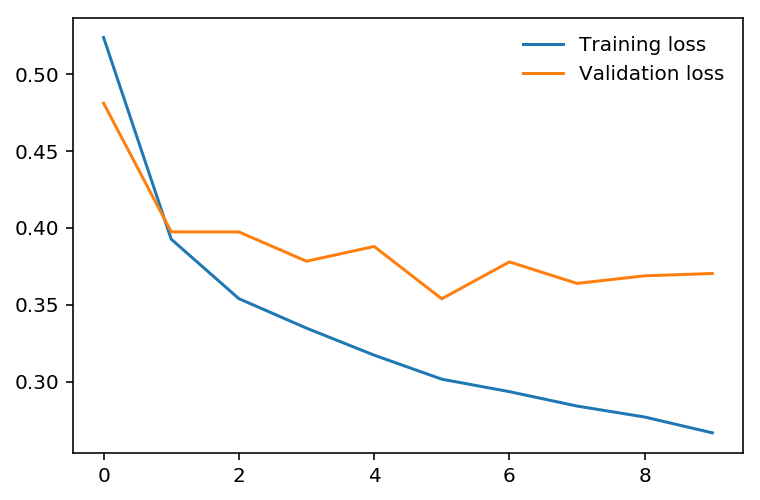

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)


## Overfitting
The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing.

- solution is **early-stopping**
- **dropout**, where we randomly drop input units.


## DropOut
- training we want to use dropout to prevent overfitting 
- during inference we want to use the entire network.
- **model.eval()** to turnoff drop out during testing.
- This sets the model to evaluation mode where the dropout probability is 0.
-  dropout back on by setting the model to train mode with **model.train()**. 

In [9]:
# Droupout using nn.Dropout
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [10]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # Turn off dropout
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Turn on dropout 
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.605..  Test Loss: 0.470..  Test Accuracy: 0.832
Epoch: 2/10..  Training Loss: 0.486..  Test Loss: 0.425..  Test Accuracy: 0.847
Epoch: 3/10..  Training Loss: 0.451..  Test Loss: 0.403..  Test Accuracy: 0.852
Epoch: 4/10..  Training Loss: 0.430..  Test Loss: 0.409..  Test Accuracy: 0.858
Epoch: 5/10..  Training Loss: 0.420..  Test Loss: 0.415..  Test Accuracy: 0.856
Epoch: 6/10..  Training Loss: 0.411..  Test Loss: 0.415..  Test Accuracy: 0.861
Epoch: 7/10..  Training Loss: 0.410..  Test Loss: 0.390..  Test Accuracy: 0.858
Epoch: 8/10..  Training Loss: 0.400..  Test Loss: 0.400..  Test Accuracy: 0.859
Epoch: 9/10..  Training Loss: 0.387..  Test Loss: 0.388..  Test Accuracy: 0.865
Epoch: 10/10..  Training Loss: 0.387..  Test Loss: 0.390..  Test Accuracy: 0.862


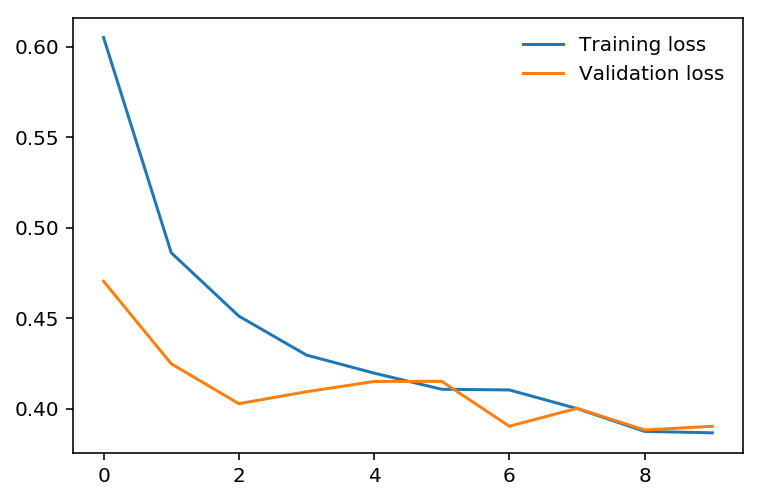

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)